# CFS字符分割-1Z实验室

## 概要

**CFS** 的全称叫做**Color Filling Segmentation**颜色填充字符分割。

它基于一个淳朴的假设，一个字符就是一个连通域，都是连在一起的。 

首先检索到图片中一个非零点，检索顺序， 从上到下， 从左到右。 然后将这个点添加到队列中。借助队列，检索上下左右相邻区域，直至蔓延到整个连通域。当前的连通域就认作是一个字符。
完成后，再继续寻找下一个非零的点。

![cfs_result.png](cfs_result.png)


## 读入图片

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot  as plt

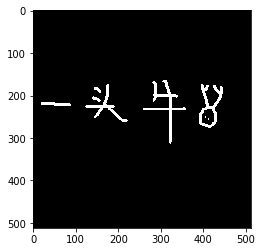

In [2]:
img = cv2.imread('demo.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

## 寻找非零点坐标

利用`visited`矩阵，记录该点是否被遍历过。 从上到下， 从左到右检索到第一个不为0的点，然后返回该点坐标。
如果未检索到，则返回`(-1,-1)`

In [3]:

def findNextStartPoint(img, visited):
    '''
    检索一个不为0的点
    '''
    PT_VISITED = 255
    # 原来的二值图片 去掉遍历过的点
    targetArea = cv2.bitwise_and(img, cv2.bitwise_not(visited))
    height,width = img.shape
    
    for y in range(height):
        for x in range(width):
            # 从上到下， 从左到右检索第一个不为0的点的坐标
            if visited[y][x]!= PT_VISITED and img[y][x] != 0:
                return (x,y)
    #不存在白点
    return (-1, -1)

## 检索连通域

`findNextStartPoint`找到起始点， 然后，将这个坐标传入`findConnectedDomain`中， 作为起始检索点。
利用数据结构**队列 Queue**来记录像素点的扩散遍历。 扩张方向为十字形， 上下左右， 如果像素点为非零，而且没有被遍历过，就添加到队列中。
如果队列为空，则标志着当前连通域遍历完成。


In [4]:
def findConnectedDomain(img, start_pt):
    '''
        从起始点start_pt  (x, y) 找到该点所在的连通域
    '''
    PT_VISITED = 255
    
    height, width = img.shape
    # 十字型核 
    cross_kernel = ((0,1), (1,0), (-1,0), (0,-1))
    # 利用与img同等大小的矩阵记录访问点
    visited = np.zeros_like(img)
    # 初始化检索队列
    queue = [start_pt]
    
    while len(queue) != 0:
        # 如果队列不为空就一直执行
        # 弹出队首元素
        cur_pt = queue.pop()
        (x,y) = cur_pt
        
        if visited[y][x] == PT_VISITED:
            # 如果已经访问过就PASS
            continue
        # 标记访问过当前元素
        visited[y][x] = PT_VISITED
        
        for delta_x,delta_y in cross_kernel:
            # 下一个点的x坐标与y坐标
            next_x = x + delta_x 
            next_y = y + delta_y
            if next_x < 0 or next_x >= width or next_y < 0 or next_y >= height:
                # 索引越界判断
                continue
            if visited[next_y][next_x] == PT_VISITED:
                # 已经访问过
                continue
            if img[next_y][next_x] > 0:
                # 将符合条件的邻居添加到队列里
                queue.append((next_x, next_y))

    return visited


## CFS函数

不断寻找一个非0点像素坐标，然后寻找该点所在的整个连通域。
函数返回各个连通域对应的**罩层 Mask**数组。

In [5]:
def CFS(img):
    '''
    利用cfs算法，寻找各个连通域，并返回连通域的掩模数组
    '''
    digit_masks = []
    visited = np.zeros_like(img)
    
    while True:
        # 寻找一个非0的起始点
        start_pt = findNextStartPoint(img, visited)
        print('Start From {}'.format(start_pt))
        if start_pt[0] == -1 and start_pt[1] == -1:
            # 如果无有效起始点， 就结束
            break
        # 获取该点所在连通域的掩模
        digit_mask = findConnectedDomain(img, start_pt)
        digit_masks.append(digit_mask)
        # 更新访问矩阵
        cv2.bitwise_or(visited, digit_mask, visited)
    
    return digit_masks

In [6]:
digit_masks = CFS(img)

Start From (307, 164)
Start From (176, 172)
Start From (396, 173)
Start From (146, 181)
Start From (142, 203)
Start From (21, 216)
Start From (404, 249)
Start From (412, 253)
Start From (-1, -1)


## 效果展示

创建画布，用不同的颜色填充不同的连通域。

In [7]:
'''
在一张图片里面 使用不同的色彩对连通域进行绘制
'''
height,width = img.shape
canvas = np.zeros((height, width, 3))

for didx, mask in enumerate(digit_masks):
    digit = np.zeros((height, width, 3))
    color = np.random.randint(0, 255, (3))
    print('color: {}'.format(color))
    digit[:] = color
    digit = cv2.bitwise_or(canvas, digit, mask=mask)
    canvas += digit

## 保存图片
cv2.imwrite('cfs_result.png', canvas)

color: [ 57 240 129]
color: [ 19  20 249]
color: [103 123 170]
color: [152 183  59]
color: [188 157  25]
color: [141  36 237]
color: [  8 132  80]
color: [224  34 207]


True

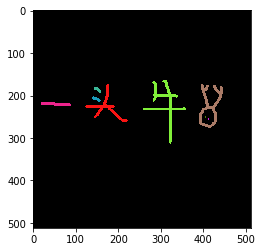

In [8]:
img = cv2.imread('cfs_result.png')
plt.imshow(img[:,:,::-1])
plt.show()